# Outline

- create a model that predicts the category of each article by Recurrent Neural Network with **pre-trained word embeddings**
- train data is `matichon.json` that contains about 17K articles of Thai news by Matichon between 2015-2018
- X is `headline` of news
- y is category (10 labels)
- pre-trained word embedding is `word2vec_matichoon.model` that is trained from the articles
- F1 score of Logistic Regression using headline : **0.71**

# Import

In [1]:
import pandas as pd
import numpy as np
import re, emoji, urllib, html

from keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Attention, Concatenate, GlobalMaxPool1D
from keras.models import Model
from keras.utils import plot_model, to_categorical, pad_sequences

from gensim.models import Word2Vec

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from pythainlp.tokenize import word_tokenize

- custom tokenization function
- remove all quotations and shrink newlines `\n` and white spaces 

In [2]:
def my_tokenize(text):
    ### REMOVE URL ###
    text = html.unescape(urllib.parse.unquote(text)) # unescape for unicode, unquote for escaped URL
    text = re.sub(r'https?.+?(?:\s|$)', '', text) # remove URL link
    ### REMOVE EMOJI ###
    text = emoji.replace_emoji(text) # remove emoji
    ### REPLACE ###
    text = re.sub(r'[“”„\"]', '', text) # remove double quotations
    text = re.sub(r'[‘’′′′′`\']', '', text) # remove single quotations
    text = re.sub(r'[\n\t\u00a0\xa0\u3000\u2002-\u200a\u202f]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'เเ', 'แ', text)
    ### SHRINK SOME REDUPLICATION ###
    text = re.sub(r'าา+', 'า', text)
    text = re.sub(r'ยย+', 'ย', text)
    text = re.sub(r'ๆๆ+', 'ๆ', text)
    text = re.sub(r'ะะ+', 'ะ', text)
    ### am ###
    text = re.sub(r'ํา','ำ', text) # o + า -> ำ
    text = re.sub(r'\u0E33([\u0E48\u0E49\u0E4A\u0E4B])', r'\1'+'\u0E33', text) # am + tone -> tone + am
    ### TOKENIZE AND FILTERING ###
    tokens = word_tokenize(text, keep_whitespace=False)
    tokens = [token.strip('(').strip(')') for token in tokens]
    tokens = [token for token in tokens if re.match(r'[A-zก-ไ][A-zก-๙\.]*', token)]
    return tokens

# Load data

- target variable is `category`
- `headline` and `article` are untokenized text

In [3]:
## load pre-trained word vector
wv_model = Word2Vec.load("data/word2vec_matichon.model")

## load matichon news data
## drop "date", "article", "url", and "id"
df = pd.read_json('data/matichon.json')
df.drop(columns=['date','article','url','id'], inplace=True)

df

,headline,category
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,foreign
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...",politics
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",entertainment
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",entertainment
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",entertainment
...,...,...
17104,โบว์ ณัฏฐา แจ้งความ พล.ต.อ.ศรีวราห์ ถูกพาดพิง...,politics
17105,ภาพบรรยากาศ ขุดทางระบายน้ำ เร่งนำ 13 ชีวิตออกจ...,region
17106,สนช.ผ่านพ.ร.บ.สงฆ์ 3 วาระรวด พระมหากษัตริย์ทรง...,politics
17107,นานาทรรศนะเพิ่มค่าปรับหมอ 5ล้านบ. สกัดเบี้ยว...,education


In [4]:
## value counts of target variable
df.category.value_counts()

politics         3135
region           2655
crime            2141
local            1938
publicize        1481
foreign          1329
economy          1249
sport            1202
education        1053
entertainment     926
Name: category, dtype: int64

# Preprocessing

### tokenize

- it may take more than 2 minutes
- you can save the tokenized file by `df.to_json('XXX.json', orient='records')`

In [5]:
df['tokens'] = df['headline'].apply(my_tokenize)
df.head()

,headline,category,tokens
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,foreign,"[ซาอุฯ, จ่อ, เปิดไฟเขียว, ให้, สิทธิ, หญิง, ม่..."
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...",politics,"[ไก่อู, ชี้, ตู่, เต้น, ไม่, ได้, มี, หน้าที่,..."
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",entertainment,"[เปิดใจ, โบว์, แวนดา, ระหว่าง, รอ, ยิ้ม, ได้, ..."
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",entertainment,"[นาย, ณ, ภัทร, ปลื้ม, คน, ชม, แชมป์, ขึ้น, ปก,..."
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",entertainment,"[คอ, แทบ, หัก, แม่ยก, แห่, คล้อง, พวงมาลัย, ัก..."


In [6]:
## check min & max length of tokens
print('Min Length:', df['tokens'].apply(len).min())
print('Max Length:', df['tokens'].apply(len).max())

Min Length: 4
Max Length: 110


### indexing & one-hot-encoding

- indexing(label encoding) is a process to convert categorical data into numerical form
~~~python
vocab : {'อร่อย':0, 'ไทย':1,...}
y : {'crime':0, 'economy':1,...}
~~~

- one-hot-encoding is also required for `y` to pass to a NN model

In [7]:
## make vocaburary list
all_vocabs = sorted(set.union(*df['tokens'].apply(set)))
print('total vocab in headline :', len(all_vocabs))

## indexing for vocab
vocab2index = {'<PADDING>':0, '<END>':1} # special symbol for padding and EoS
for i, vocab in enumerate(all_vocabs):
    vocab2index[vocab] = len(vocab2index)

## label encoding for y
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(df['category'])

## one-hot-encoding
y = to_categorical(y, num_classes=len(y_encoder.classes_))

total vocab in headline : 18353


### create `X` sequence and train-test splitting

- max length = 110

In [8]:
MAX_LENGTH = 110

X = [[vocab2index[token] for token in tokens]+[1] for tokens in df['tokens']]
X = pad_sequences(X, maxlen=MAX_LENGTH, padding="post")

X

array([[ 4423,  3887, 15447, ...,     0,     0,     0],
       [18023,  4232,  5425, ...,     0,     0,     0],
       [15444, 17581, 17172, ...,     0,     0,     0],
       ...,
       [11927,  8290,  8386, ...,     0,     0,     0],
       [ 6608,  5726, 15652, ...,     0,     0,     0],
       [11276,  6616, 11772, ...,     0,     0,     0]], dtype=int32)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['category'], random_state=42)

print('TRAIN:', X_train.shape, y_train.shape)
print('TEST :', X_test.shape, y_test.shape)

TRAIN: (13687, 110) (13687, 10)
TEST : (3422, 110) (3422, 10)


In [10]:
y_encoder.inverse_transform(np.argmax(y_train, axis=1))

array(['entertainment', 'crime', 'politics', ..., 'politics', 'politics',
       'politics'], dtype=object)

# Modelling

### create LSTM model

2023-11-03 09:10:57.375717: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-03 09:10:57.375743: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-03 09:10:57.375751: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-03 09:10:57.375790: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-03 09:10:57.375811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


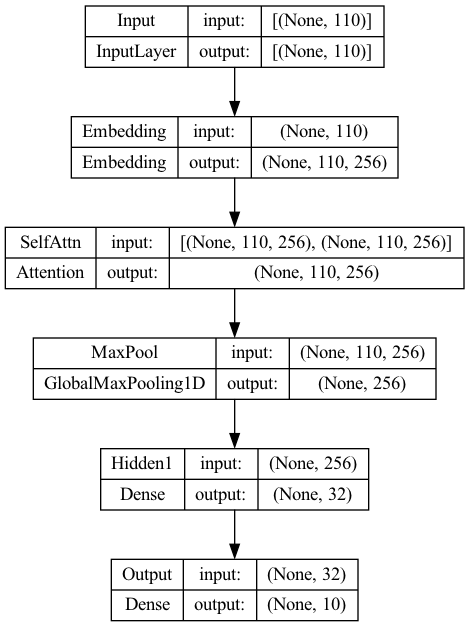

In [11]:
## constants
VOCAB_SIZE = len(vocab2index)
EMBEDDING_DIM = 256
LSTM_DIM = 128

## Make Model with Functional API
## Define Layers
input_layer = Input(shape=(X_train.shape[-1],), name='Input')
embedding = Embedding(input_dim=VOCAB_SIZE,
                    input_length=X_train.shape[-1],
                    output_dim=EMBEDDING_DIM,
                    mask_zero=True, # let LSTM ignore padding
                    name = 'Embedding')
lstm = Bidirectional(LSTM(LSTM_DIM, 
                        return_sequences=True, 
                        return_state=False,
                        recurrent_dropout=0.2,
                        name='LSTM1'), name='BiLSTM')
concat = Concatenate(name='Concat')
attention = Attention(name='SelfAttn')
max_pool = GlobalMaxPool1D(name='MaxPool')
hidden_1 = Dense(32, activation='relu', name='Hidden1')
output_layer = Dense(y_train.shape[-1], activation='softmax', name='Output')

## Build Model
x = embedding(input_layer)
#x = lstm(x)
x = attention([x, x])
x = max_pool(x)
x = hidden_1(x)
x = output_layer(x)

model = Model(inputs=[input_layer], outputs=[x])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

## plot model
plot_model(model, show_shapes=True)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 110)]                0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 110, 256)             4698880   ['Input[0][0]']               
                                                                                                  
 SelfAttn (Attention)        (None, 110, 256)             0         ['Embedding[0][0]',           
                                                                     'Embedding[0][0]']           
                                                                                                  
 MaxPool (GlobalMaxPooling1  (None, 256)                  0         ['SelfAttn[0][0]']        

### fit model

In [13]:
## fit
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10


2023-11-03 09:11:05.898493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-03 09:11:05.922081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


343/343 [==============================] - 9s 25ms/step - loss: 1.9402 - accuracy: 0.3328 - val_loss: 1.5554 - val_accuracy: 0.5281
Epoch 2/10
343/343 [==============================] - 8s 22ms/step - loss: 1.2828 - accuracy: 0.6091 - val_loss: 1.1906 - val_accuracy: 0.6505
Epoch 3/10
343/343 [==============================] - 8s 22ms/step - loss: 0.9508 - accuracy: 0.7098 - val_loss: 1.0475 - val_accuracy: 0.6673
Epoch 4/10
343/343 [==============================] - 8s 22ms/step - loss: 0.7703 - accuracy: 0.7550 - val_loss: 1.0148 - val_accuracy: 0.6852
Epoch 5/10
343/343 [==============================] - 8s 23ms/step - loss: 0.6666 - accuracy: 0.7919 - val_loss: 1.0155 - val_accuracy: 0.6841
Epoch 6/10
343/343 [==============================] - 8s 23ms/step - loss: 0.5967 - accuracy: 0.8166 - val_loss: 1.0356 - val_accuracy: 0.6822
Epoch 7/10
343/343 [==============================] - 9s 26ms/step - loss: 0.5423 - accuracy: 0.8323 - val_loss: 1.0718 - val_accuracy: 0.6720
Epoch 8/10

In [84]:
np.argmax(model.predict(X_test), axis=1)

107/107 [==============================] - 1s 11ms/step


array([6, 6, 6, ..., 6, 6, 6])

- validation loss increased = overfitting
- epoch 4-5 is enough

In [93]:
## predict
y_pred = NN.predict(X_test).argmax(axis=1)
y_pred = [index_2_label[i] for i in y_pred]

## print F1 scores
print(classification_report(y_test, y_pred))

81/81 [==============================] - 2s 14ms/step
               precision    recall  f1-score   support

        crime       0.54      0.56      0.55       304
      economy       0.66      0.69      0.68       181
    education       0.73      0.63      0.68       171
entertainment       0.76      0.80      0.78       144
      foreign       0.80      0.81      0.80       196
        local       0.34      0.41      0.37       283
     politics       0.83      0.81      0.82       492
    publicize       0.82      0.76      0.79       236
       region       0.60      0.55      0.57       377
        sport       0.93      0.93      0.93       183

     accuracy                           0.68      2567
    macro avg       0.70      0.69      0.70      2567
 weighted avg       0.69      0.68      0.68      2567



In [1]:
## print confusion matrix
labels = list(label_2_index.keys())

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=80)

NameError: name 'label_2_index' is not defined

- the result is not so different from logistic regression
- probably because, both logistic regression and NN use only bag-of-words features
- but, NN can get as high score as logistic regression in spite of using only unigrams

In [107]:
d = pd.DataFrame(wv_model.wv.vectors, columns=np.arange(1,101))
d['word'] = wv_model.wv.index_to_key
d['count'] = d['word'].apply(lambda x: wv_model.wv.get_vecattr(x, 'count'))
d


,1,2,3,4,5,6,7,8,9,10,...,93,94,95,96,97,98,99,100,word,count
0,-0.115129,0.060965,0.060834,0.157504,-0.059848,-0.263565,-0.001637,0.486914,-0.400752,0.058076,...,-0.067463,-0.094097,0.299715,0.067317,0.005433,-0.224779,-0.084690,-0.006395,,1489094
1,-0.195541,0.139970,0.297516,0.241935,-0.037803,-0.170059,-0.028223,0.276327,-0.352734,0.000572,...,0.021286,-0.142074,0.226557,0.236400,0.198953,-0.010393,-0.267162,-0.188302,ที่,124851
2,-0.147754,0.259351,0.105271,0.136723,0.011238,-0.230362,0.256091,0.263332,-0.106787,0.091762,...,0.115024,0.173353,0.123222,0.133086,-0.159119,-0.285581,-0.319027,-0.254555,และ,118747
3,-0.201567,0.323811,0.290726,0.386255,-0.140789,-0.144918,-0.092061,0.197636,-0.045216,-0.135357,...,-0.037931,-0.060638,0.464957,0.155730,0.274646,-0.352646,-0.050037,0.114037,ใน,98174
4,-0.225682,-0.169318,0.037102,0.283102,-0.209278,-0.094408,0.103492,0.284082,-0.361589,0.103232,...,0.008082,-0.050040,0.261000,0.134604,0.031578,-0.288187,-0.106384,-0.135669,มี,84323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34711,-0.520574,0.385575,-0.243073,0.295398,0.145430,-0.525168,0.207806,0.580581,0.161946,-0.016590,...,-0.022743,-0.008050,0.037739,0.193809,-0.110086,0.163088,0.234714,0.113841,สายสลิง,3
34712,0.139244,0.553671,-0.155242,0.329569,-0.190113,-0.046625,0.408116,0.512062,-0.405408,0.390316,...,-0.009868,-0.185350,0.254732,0.047355,-0.047969,-0.160750,0.108977,-0.163471,ฐี,3
34713,-0.372724,0.387854,0.220941,0.041686,-0.225755,-0.615183,0.641088,0.412491,-0.361425,-0.412133,...,-0.096471,0.024511,0.672394,0.019765,-0.460669,0.106494,-0.061306,-0.807174,(ฟิน,3
34714,0.264745,0.210588,-0.073326,0.197408,-0.452811,-0.735576,0.184602,0.638783,-0.118395,-0.268313,...,0.100573,0.203406,-0.257960,0.362321,0.038738,0.107868,0.303093,-0.026198,ดีดลูกคิด,3


In [110]:
d = d[d.word.str.match('[ก-ไ][ก-๙\.]*')]
d = d[d['count'] > 10]
d

,1,2,3,4,5,6,7,8,9,10,...,93,94,95,96,97,98,99,100,word,count
1,-0.195541,0.139970,0.297516,0.241935,-0.037803,-0.170059,-0.028223,0.276327,-0.352734,0.000572,...,0.021286,-0.142074,0.226557,0.236400,0.198953,-0.010393,-0.267162,-0.188302,ที่,124851
2,-0.147754,0.259351,0.105271,0.136723,0.011238,-0.230362,0.256091,0.263332,-0.106787,0.091762,...,0.115024,0.173353,0.123222,0.133086,-0.159119,-0.285581,-0.319027,-0.254555,และ,118747
3,-0.201567,0.323811,0.290726,0.386255,-0.140789,-0.144918,-0.092061,0.197636,-0.045216,-0.135357,...,-0.037931,-0.060638,0.464957,0.155730,0.274646,-0.352646,-0.050037,0.114037,ใน,98174
4,-0.225682,-0.169318,0.037102,0.283102,-0.209278,-0.094408,0.103492,0.284082,-0.361589,0.103232,...,0.008082,-0.050040,0.261000,0.134604,0.031578,-0.288187,-0.106384,-0.135669,มี,84323
5,-0.732108,0.526433,0.061710,-0.147568,-0.245569,0.075485,0.395819,0.480405,-0.251592,-0.189021,...,-0.343269,0.300721,0.000155,0.027500,0.080456,-0.303176,-0.244376,-0.063076,การ,74990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19180,-0.511371,0.547844,-0.161213,-0.477905,-0.675610,-0.457605,0.066567,0.387715,-0.158202,0.521220,...,0.214856,-0.985535,0.412029,0.353362,0.010676,-0.032127,0.019349,-0.036783,ทซ์,11
19182,0.346861,0.189414,-0.416946,-0.169440,0.167507,-0.614762,-0.635954,0.350737,-0.320667,-0.152160,...,0.209515,-0.314288,-0.485094,0.355914,-0.184608,-0.957290,0.014739,0.119618,ไข่ปลา,11
19183,-0.069712,0.184935,-0.277014,0.262183,-0.545540,-0.811943,0.087696,0.181747,-0.833991,0.291843,...,0.126096,-0.023551,0.026386,-0.241637,-0.358346,-0.120424,0.404603,0.236597,ราชสีห์,11
19184,-0.478088,0.373022,0.579845,0.283651,-0.037221,-0.407584,0.244382,-0.450111,-0.485570,-0.221021,...,0.058011,-0.186824,-0.607172,0.025505,0.080728,0.119294,0.892142,-0.263846,บอยคอต,11
